In [ ]:
# DRAE Combinación
# 1. Se generan diversos incrustamientos con un diversos métodos RD
# 2. Se utiliza los incrustamientos como referentes para entrednar Encoders
# 3. Se comibinan distintos Encoders para generar un nuevo incrustamiento

In [ ]:
!nvidia-smi

In [ ]:
pip install MKLpy

In [ ]:
pip install score-rnx==0.3

In [ ]:
########################################################################
# Para vincular el espacio de trabajo de drive
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
from google.colab import drive
drive.mount('/content/drive') # Esta no es la ruta del drive, es la ruta interna de colab
%cd /content/drive/MyDrive/TesisCode/DRAE

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import math
import random
 
from KPCA import K_rbf, K_polinomial, kpca, kpcaRBF,  kpcaPoli, pca, pca2
from LLE import klleGpu, K_de_lle, lle
from MDS import kcmdsGpu, K_de_cmds, mds
from LE import kleGpu, K_de_le, kleGpu2, K_de_le2, le, ler
from AEclasico import AEclasico, loadAEclasico
from Data import loadDataTensor
from RD import aplicacionRD, getListaRd
 
import csv
 
from cluster import menuCluster
 
from rdEncoder import rdEnc, loadRdEnc

from time import time
 
#torch.cuda.set_device(device)
#print(torch.cuda.get_device_name(device=None))
 
#import pdb   pdb.set_trace()  # para hacer debug

# Para RNX *****
#pip install score-rnx==0.3  # Para instalar la librería RNX
#https://github.com/DiegoUrrea195/score_rnx
# from Rnx import nx_scores
                                          
                                            # **** UTILS **** #
    
########################################################################
# Procedimiento para graficar el scatter plot del encoder (code)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
def graficar(mat, bdMet):
    matx = mat[:,0]
    maty = mat[:,1] 
    ets = mat[:,2]
    numEt = len(clases)
    plt.scatter(matx, maty, c=ets, label=clases, cmap=plt.cm.get_cmap('jet', numEt))
    
    if bdMet: # para saber si muestra las etiquetas en el gráfico o no
        for label, x, y in zip(ets, matx, maty):
            plt.annotate(
               label,
               xy=(x, y), xytext=(-20, 20),
               textcoords='offset points', ha='right', va='bottom',
               bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
               arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    plt.show()
    
########################################################################
# Procedimiento para graficar el scatter plot del encoder (code) con etiquetas diferentes al conjunto original
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
def graficarConEtClus(mat, etCluster, bdMet):
    matx = mat[:,0]
    maty = mat[:,1] 
    numEt = len(clases)
    plt.scatter(matx, maty, c=etCluster, marker='o', label=clases, cmap=plt.cm.get_cmap('jet', numEt))
    
    if bdMet: # para saber si muestra las etiquetas en el gráfico o no
        for label, x, y in zip(etCluster, matx, maty):
            plt.annotate(
               label,
               xy=(x, y), xytext=(-20, 20),
               textcoords='offset points', ha='right', va='bottom',
               bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
               arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
                               
########################################################################
# Grafica la rd de un modelo cargado
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
def graficarRdModel(pos):
    metodo = listaModelos[pos]
    x=metodo.rd[:,0]
    y=metodo.rd[:,1] 
    numEt = len(clases)
    plt.scatter(x, y, c=labelsIn, label=clases, cmap=plt.cm.get_cmap('jet', numEt))
    plt.show()
            
########################################################################
# Genera una matriz de graficas que contiene la RD de un método, la clusterización y la intersección
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
def matGraficos(metodos, interseccion, centroides):
 
    nmets = len(metodos)
    fig = plt.figure(figsize=(20,20))
    print("nmets",nmets)
    cn=1
    for met in metodos:
        subplot(nmets,3,cn)
        graficar(met.rd, False)
        title(met.nombre+' Rd')
        cn=cn+1
 
        subplot(nmets,3,cn)
        graficarConEtClus(met.rd, met.cluster, False)
        title('Clus')
        cn=cn+1
 
        subplot(nmets,3,cn)
        graficar(interseccion, False)
        scatter(centroides[:,0], centroides[:,1] , c="black",  marker='*', s=300)
        title('Int')
        cn=cn+1
        
########################################################################
# Función para guardar los datos de entrada Xin
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
def guardarXL(nombreDB):
    print("Guardando Xin y el labelsIn...")        
    with open('./RNXmat/Xin'+nombreDB+'.dat', 'w', newline='', encoding='utf-8') as csvfile2:
        writer = csv.writer(csvfile2)
        writer.writerows(Xin)
        
    output_array = np.array(labelsIn)
    np.savetxt("./RNXmat/labelsIn"+nombreDB+".csv", output_array, delimiter=",")

########################################################################
# Función para guardar archivo para RNX de la combinacion
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
def guardarRdRnx(nombreRd, datos):
    with open('./RNXmat/'+ nombreRd +'.dat', 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(datos)  
        
########################################################################
# Función para guardar archivo RD de métodos originales, utilizada para hacer ensamble de métodos rd
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
def guardarRDensamble(nombreRd, datos):
    ruta2d = "./model/2d_RD_" + nombreRd + ".csv"
    with open(ruta2d, 'w', newline='', encoding='utf-8') as csvfile2rd:
        writer = csv.writer(csvfile2rd)
        writer.writerows(datos)  
        
########################################################################
# procedimiento para guardar imagenes del out (decoder)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
from torchvision.utils import save_image
import os
 
if not os.path.exists('./decodeImgs'):
    os.mkdir('./decodeImgs')
    
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    
    if rowImg==28:
        x = x.view(x.size(0), 1, 28, 28)
    elif rowImg==32:
        x = x.view(x.size(0), 1, 32, 32)
    elif rowImg==20:
        x = x.view(x.size(0), 1, 28, 20)
    
    return x
 
# guarda las imagenes del out (decode)
def guardarImagenesDec(nomImgDec, decodes):
    #decodes=torch.from_numpy(decodes).cuda()
    for i in range(len(decodes)):
        pic = to_img(decodes[i])
        save_image(pic, './decodeImgs/Ensamblaje'+nomImgDec+'_{}.png'.format(i))   
    
########################################################################
# Clusters
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
def clusteres(rdEnc):
    Xclu = rdEnc[:,:d]
    print("d", d)
    print("Xclu", Xclu.shape)
    menuCluster(Xclu, labelsIn, len(clases))
    
########################################################################
# Genera el decoder
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
from modeloAE import Decoder2820, Decoder28, Decoder32, weights_init
 
def getDecoder(rdEnc):
 
    if rowImg==28: # para imagenes como mnist que son de 28*28
        decoder = Decoder28(codesize=2).apply(weights_init)
        decoder.cuda()
    elif rowImg==32: # para imagenes como Coil20 o CIFAR que son de 32*32 con diferente numero de canales
        decoder = Decoder32(codesize=2,nChanelsIn=nCh).apply(weights_init)
        decoder.cuda()
    elif rowImg==20: # para imagenes como face que son de 28*20
        decoder = Decoder2820(codesize=2).apply(weights_init)
        decoder.cuda()
 
    #criterion = nn.SmoothL1Loss().cuda()
    criterion = nn.MSELoss() # error
 
    learning_rate = 0.001  #0.0001 0.001 #1e-3
    optimizerDec = optim.Adam(decoder.parameters(), lr=learning_rate, weight_decay=1e-5) # 0.01  1e-5
 
    # Train the network (DECODER)
    from torch.autograd import Variable
    from tqdm import tqdm # barra de tiempo
 
    if rowImg==28:
        decodes = np.random.rand(0, 1, 28, 28)
    elif rowImg==20:
        decodes = np.random.rand(0, 1, 28, 20)
    elif rowImg==32:
        decodes = np.random.rand(0, 1, 32, 32)
 
    print('Start Training Decode')
    numepochs = 1000 #100 
    for epoch in tqdm(range(numepochs)):  
    
        for i, data  in enumerate(trainloader, 0): # recorre las imagenes por minilotes. El tamaño del minilote se estableció en 64 (batch_size=64) por lo que el trainloader carga minilotes de 64 imagenes (inputs torch.Size([64, 1, 28, 28] es decir [tamaño minilote, 1, 28, 28] en otras palabras: 64 imagens monocromaticas (1 canal rgb) de 28x28 pixeles))
            # get the inputs
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
 
            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels) # la función Variable (obsoleta creo) creo que es similar a poner requires_grad=True
        
            # zero the parameter gradients
            optimizerDec.zero_grad()
        
            # ===============Adapta el tamaño del encodeRd al minilote (para poder comparar el code con el subcojunto mini de RD)
            encodeRdMini = rdEnc[list(trainloader._index_sampler)[i]]
            encodeRdMini = torch.from_numpy(encodeRdMini).cuda()
            encodeRdMini = encodeRdMini.float()
            #==========================================================
 
            # *** forward + backward + optimize
            out = decoder(encodeRdMini) # forward
        
            if epoch==numepochs-1: #solo guardo en la ultima epoca, donde los parametros ya han sido optimizados
                decodes = np.concatenate((decodes, out.cpu().data), axis=0)
        
            loss = criterion(inputs, out) # backward
            loss.backward() # backward
        
            optimizerDec.step() # optimize
 
        if epoch % int(0.1*numepochs) == 0:
            print(f'epoch {epoch} \t Loss: {loss.item():.4g}')
         
    print('Finished Training Decode')
 
    torch.save(decoder.state_dict(), "./model/DecodeCombinacion.model")
    
    return decodes

########################################################################
# Carga un archivo
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
def loadFile(nombreFile):
    matL = np.transpose(np.loadtxt("./RNXmat/"+nombreFile+".dat", delimiter=',', unpack=True))
    return matL

########################################################################
# Carga un archivo Matlab
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
def loadFileMatlab(nombreFile, vep):
    import scipy.io
    mat = scipy.io.loadmat("./RNXmat/"+nombreFile+".mat") 
    Xmat = mat[vep] # vep es el nombre de la variable en el espacio de trabajo en matlab
    Xmat = np.column_stack((Xmat, labelsIn))
    return Xmat

########################################################################
# Clase Métodos rd
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
class MetodoRd:
    nombre = ""
    tipo = "" # clasico o kernel
    rd = object
    K = object
    cluster = np.random.rand(0) #np.array([[0]])
    subsetsCluster = {}
    etTamanoSubsets = []
    rnx = 0
    metricasCluster = 0
    indexOriginales = []
    
########################################################################
# Clase Modelos de Métodos rd
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 
class ModelMetodoRd:
    model = object
    rd = object
    
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1060'

DataSets
	1 - Generación de datos de la fuente
	2 - Carga de datos desde archivo generado
	Z - Salir


Seleccione la opción: >>  2


Cargando Trainloader, Xin y LabelsIn asociados al modelo...
MENU DE DATOS TENSORIALES
	1 - FashionMNIST
	2 - MNIST
	3 - CIFAR
	4 - Coil20
	5 - Faces
	6 - Tufts
	7 - naturalImages
	8 - Signs
	9 - FER
	10 - Chess
	11 - Lego
	20 - Salir


Selecciona una opción >>  11



Has selecionado el data set Legos


D:\Drive\TesisCode\DRAE\Data.py:956: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  classes = torch.range(0,16,1)


images  torch.Size([64, 1, 32, 32])
labels  torch.Size([64])


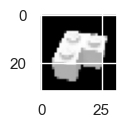

tamaño del cojunto de datos o lote 6379
tamaño del mini lote 64
numero de minilotes  100
X  torch.Size([6379, 1, 32, 32])
y torch.Size([6379])


In [20]:
#### # 1. DATOS  (para entrenar)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
clases = ""
trainloader, clases, Xin, labelsIn, Xint, dimImg, rowImg, nCh, nombreDB = loadDataTensor() # aqui las etiquetas las estoy tomando como clases
nc = len(clases)
fl= len(Xin)
cl=2 # dimensiones1

In [10]:
# Datos con otro tamaño del minilote   (PARA CARGAR EL ENCODER)
X2 = Xint.reshape(-1,nCh,rowImg,dimImg)
dataset = torch.utils.data.TensorDataset(X2, labelsIn)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=3000, shuffle=False)

MENU DE COMBINACION RD
	A - Aplicación de métodos RD
	B - Cargar incrustamientos RD
	C - Generar modelos Encoder
	D - Cargar modelos Encoder
	Z - Salir


Seleccione la opción: >>  d


Carga de modelos Encoder


Suministre la dimensión del incrustamiento:  >>  2


Finished Loading: PCA
Finished Loading: CMDSsk


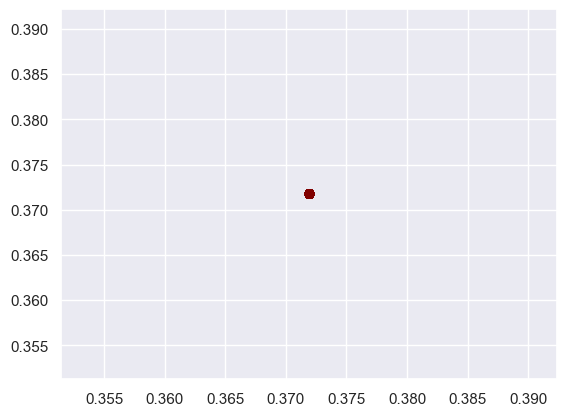

Finalización de la Carga de modelos Encoder


In [22]:
### # Generación de incrustamiento
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 
print ("MENU DE COMBINACION RD")
print ("\tA - Aplicación de métodos RD")
print ("\tB - Cargar incrustamientos RD")
print ("\tC - Generar modelos Encoder")
print ("\tD - Cargar modelos Encoder")
print ("\tZ - Salir")
opcionEnc = input("Seleccione la opción: >> ")
 
listaMetodos = list()
listaModelos = list()
 
if opcionEnc=="A" or opcionEnc=="a":
    
    d = int(input("Suministre la dimensión del incrustamiento:  >> "))
    cn=0
    opcionRepiteRd = "S"
    while opcionRepiteRd == "S" or opcionRepiteRd == "s":
        cn+=1
        print("Aplicación de métodos RD: ", cn)
        encodeRd, kernel, metrd = aplicacionRD(Xint, labelsIn, clases, d) # labelsIn solo para apredizaje supervisado LDA, los demás métodos no requieren
        encodeRd = encodeRd.cpu().detach().numpy()
        encodeRd = np.column_stack((encodeRd, labelsIn))
        guardarRDensamble(metrd, encodeRd) # para hacer endamble de métodos originales
        guardarRdRnx(metrd+nombreDB, encodeRd) # para evaluar el incrustamiento con Rnx
        print("Incrustamiento: ",encodeRd.shape)
        graficar(encodeRd,False)
 
        if metrd=="CMDS":
            cmds = MetodoRd()
            cmds.nombre = "CMDS"
            cmds.tipo = "clasico"
            cmds.rd = encodeRd
            ###cmds.rnx = funcion que calcula rnx
            cmds.indexOriginales = range(fl)
            listaMetodos.append(cmds)
            
        if metrd=="LLE":
            lle = MetodoRd()
            lle.nombre = "LLE"
            lle.tipo = "clasico"
            lle.rd = encodeRd
            lle.indexOriginales = range(fl)
            listaMetodos.append(lle)
 
        if metrd=="LE":
            le = MetodoRd()
            le.nombre = "LE"
            le.tipo = "clasico"
            le.rd = encodeRd
            le.indexOriginales = range(fl)
            listaMetodos.append(le)
            
        if metrd=="CMDSsk":
            cmdssk = MetodoRd()
            cmdssk.nombre = "CMDSsk"
            cmdssk.tipo = "clasico"
            cmdssk.rd = encodeRd
            ###cmds.rnx = funcion que calcula rnx
            cmdsr.indexOriginales = range(fl)
            listaMetodos.append(cmdssk)
            
        if metrd=="CMDSr":
            cmdsr = MetodoRd()
            cmdsr.nombre = "CMDSr"
            cmdsr.tipo = "clasico"
            cmdsr.rd = encodeRd
            ###cmds.rnx = funcion que calcula rnx
            cmdsr.indexOriginales = range(fl)
            listaMetodos.append(cmdsr)
            
        if metrd=="LLEr":
            ller = MetodoRd()
            ller.nombre = "LLEr"
            ller.tipo = "clasico"
            ller.rd = encodeRd
            ###cmds.rnx = funcion que calcula rnx
            ller.indexOriginales = range(fl)
            listaMetodos.append(leer)
            
        if metrd=="LEr":
            ler = MetodoRd()
            ler.nombre = "LEr"
            ler.tipo = "clasico"
            ler.rd = encodeRd
            ###cmds.rnx = funcion que calcula rnx
            ler.indexOriginales = range(fl)
            listaMetodos.append(ler)
 
        if metrd=="PCA":
            pca = MetodoRd()
            pca.nombre = "PCA"
            pca.tipo = "clasico"
            pca.rd = encodeRd
            pca.indexOriginales = range(fl)
            listaMetodos.append(pca)
 
        if metrd=="LDA":
            lda = MetodoRd()
            lda.nombre = "LDA"
            lda.tipo = "clasico"
            lda.rd = encodeRd
            lda.indexOriginales = range(fl)
            listaMetodos.append(lda)
 
        if metrd=="KCMDS":
            kcmds = MetodoRd()
            kcmds.nombre = "KCMDS"
            kcmds.tipo = "kernel"
            kcmds.rd = encodeRd
            kcmds.K = kernel
            kcmds.indexOriginales = range(fl)
            listaMetodos.append(kcmds)
 
        if metrd=="KLLE":
            klle = MetodoRd()
            klle.nombre = "KLLE"
            klle.tipo = "kernel"
            klle.rd = encodeRd
            klle.K = kernel
            klle.indexOriginales = range(fl)
            listaMetodos.append(klle)
 
        if metrd=="KLE":
            kle = MetodoRd()
            kle.nombre = "KLE"
            kle.tipo = "kernel"
            kle.rd = encodeRd
            kle.K = kernel
            kle.indexOriginales = range(fl)
            listaMetodos.append(kle)
 
        if metrd=="KPCApoli":
            kpcaPoli = MetodoRd()
            kpcaPoli.nombre = "KPCApoli"
            kpcaPoli.tipo = "kernel"
            kpcaPoli.rd = encodeRd
            kpcaPoli.K = kernel
            kpcaPoli.indexOriginales = range(fl)
            listaMetodos.append(kpcaPoli)
 
        if metrd=="KCMDSpoli":
            kcmdsPoli = MetodoRd()
            kcmdsPoli.nombre = "KCMDSpoli"
            kcmdsPoli.tipo = "kernel"
            kcmdsPoli.rd = encodeRd
            kcmdsPoli.K = kernel
            kcmdsPoli.indexOriginales = range(fl)
            listaMetodos.append(kcmdsPoli)
 
        if metrd=="KLLEpoli":
            kllePoli = MetodoRd()
            kllePoli.nombre = "KLLEpoli"
            kllePoli.tipo = "kernel"
            kllePoli.rd = encodeRd
            kllePoli.K = kernel
            kllePoli.indexOriginales = range(fl)
            listaMetodos.append(kllePoli)
 
        if metrd=="KLEpoli":
            klePoli = MetodoRd()
            klePoli.nombre = "KLEpoli"
            klePoli.tipo = "kernel"
            klePoli.rd = encodeRd
            klePoli.K = kernel
            klePoli.indexOriginales = range(fl)
            listaMetodos.append(klePoli)
 
        if metrd=="KPCArbf":
            kpcaRbf = MetodoRd()
            kpcaRbf.nombre = "KPCArbf"
            kpcaRbf.tipo = "kernel"
            kpcaRbf.rd = encodeRd
            kpcaRbf.K = kernel
            kpcaRbf.indexOriginales = range(fl)
            listaMetodos.append(kpcaRbf)
            
        if metrd=="MKLlineal":
            mkl = MetodoRd()
            mkl.nombre = "MKLlineal"
            mkl.tipo = "kernel"
            mkl.rd = encodeRd
            mkl.K = kernel
            mkl.indexOriginales = range(fl)
            listaMetodos.append(mkl)
            
        if metrd=="TSNE":
            tsne = MetodoRd()
            tsne.nombre = metrd
            tsne.tipo = "clasico"
            tsne.rd = encodeRd
            tsne.K = kernel
            tsne.indexOriginales = range(fl)
            listaMetodos.append(tsne)
            
        if metrd=="FACTOR":
            factor = MetodoRd()
            factor.nombre = metrd
            factor.tipo = "clasico"
            factor.rd = encodeRd
            factor.K = kernel
            factor.indexOriginales = range(fl)
            listaMetodos.append(factor)
        
        opcionRepiteRd = "N"
        #opcionRepiteRd = input("Desea aplicar otro método RD? (S/N): >> ")
    print("Modelos generados: ", len(listaMetodos))
    
if opcionEnc=="B" or opcionEnc=="b":
    print("Carga de incrustamientos RD")
    cmds = MetodoRd()
    cmds.nombre = "CMDS"
    cmds.tipo = "clasico"
    cmds.rd = np.transpose(np.loadtxt("./model/2d_RD_CMDS.csv", delimiter=',', unpack=True))
    cmds.rnx = 39.8
    cmds.indexOriginales = range(fl)
    listaMetodos.append(cmds)
        
    #lle = MetodoRd()
    #lle.nombre = "LLE"
    #lle.tipo = "clasico"
    #lle.rd = np.transpose(np.loadtxt("./model/2d_RD_LLE.csv", delimiter=',', unpack=True))
    #lle.rnx = 29.5
    #lle.indexOriginales = range(fl)
    #listaMetodos.append(lle)
        
    #le = MetodoRd()
    #le.nombre = "LE"
    #le.tipo = "clasico"
    #le.rd = np.transpose(np.loadtxt("./model/2d_RD_LE.csv", delimiter=',', unpack=True))
    #le.rnx = 33.5
    #le.indexOriginales = range(fl)
    #listaMetodos.append(le)
        
    #pca = MetodoRd()
    #pca.nombre = "PCA"
    #pca.tipo = "clasico"
    #pca.rd = np.transpose(np.loadtxt("./model/2d_RD_PCA.csv", delimiter=',', unpack=True))
    #pca.indexOriginales = range(fl)
    #listaMetodos.append(pca)
    
    #lda = MetodoRd()
    #lda.nombre = "LDA"
    #lda.tipo = "clasico"
    #lda.rd = np.transpose(np.loadtxt("./model/2d_RD_LDA.csv", delimiter=',', unpack=True))
    #lda.rnx = 35.8
    #lda.indexOriginales = range(fl)
    #listaMetodos.append(lda)
        
    #kcmds = MetodoRd()
    #kcmds.nombre = "KCMDS"
    #kcmds.tipo = "kernel"
    #kcmds.rd = np.transpose(np.loadtxt("./model/2d_RD_KCMDS.csv", delimiter=',', unpack=True))
    #kcmds.rnx = 36.7
    #kcmds.indexOriginales = range(fl)
    #listaMetodos.append(kcmds)
        
    #klle = MetodoRd()
    #klle.nombre = "KLLE"
    #klle.tipo = "kernel"
    #klle.rd = np.transpose(np.loadtxt("./model/2d_RD_KLLE.csv", delimiter=',', unpack=True))
    #klle.rnx = 29.5
    #klle.indexOriginales = range(fl)
    #listaMetodos.append(klle)
        
    #kle = MetodoRd()
    #kle.nombre = "KLE"
    #kle.tipo = "kernel"
    #kle.rd = np.transpose(np.loadtxt("./model/2d_RD_KLE.csv", delimiter=',', unpack=True))
    #kle.rnx = 33.4
    #kle.indexOriginales = range(fl)
    #listaMetodos.append(kle)
        
    #kpcaPoli = MetodoRd()
    #kpcaPoli.nombre = "KPCApoli"
    #kpcaPoli.tipo = "kernel"
    #kpcaPoli.rd = np.transpose(np.loadtxt("./model/2d_RD_KPCApoli.csv", delimiter=',', unpack=True))
    #kpcaPoli.rnx = 32.9
    #kpcaPoli.indexOriginales = range(fl)
    #listaMetodos.append(kpcaPoli)
        
    #kcmdsPoli = MetodoRd()
    #kcmdsPoli.nombre = "KCMDSpoli"
    #kcmdsPoli.tipo = "kernel"
    #kcmdsPoli.rd = np.transpose(np.loadtxt("./model/2d_RD_KCMDSpoli.csv", delimiter=',', unpack=True))
    #kcmdsPoli.rnx = 31.2
    #kcmdsPoli.indexOriginales = range(fl)
    #listaMetodos.append(kcmdsPoli)
        
    #kllePoli = MetodoRd()
    #kllePoli.nombre = "KLLEpoli"
    #kllePoli.tipo = "kernel"
    #kllePoli.rd = np.transpose(np.loadtxt("./model/2d_RD_KLLEpoli.csv", delimiter=',', unpack=True))
    #kllePoli.rnx = 31.1
    #kllePoli.indexOriginales = range(fl)
    #listaMetodos.append(kllePoli)
        
    #klePoli = MetodoRd()
    #klePoli.nombre = "KLEpoli"
    #klePoli.tipo = "kernel"
    #klePoli.rd = np.transpose(np.loadtxt("./model/2d_RD_KLEpoli.csv", delimiter=',', unpack=True))
    #klePoli.rnx = 35.4
    #klePoli.indexOriginales = range(fl)
    #listaMetodos.append(klePoli)
        
    #kpcaRbf = MetodoRd()
    #kpcaRbf.nombre = "KPCArbf"
    #kpcaRbf.tipo = "kernel"
    #kpcaRbf.rd = np.transpose(np.loadtxt("./model/2d_RD_KPCArbf.csv", delimiter=',', unpack=True))  
    #kpcaRbf.rnx = 23.0
    #kpcaRbf.indexOriginales = range(fl)
    #listaMetodos.append(kpcaRbf)
    
    #le = MetodoRd()
    #le.nombre = "CMDSr"
    #le.tipo = "clasico"
    #le.rd = np.transpose(np.loadtxt("./model/2d_RD_CMDSr.csv", delimiter=',', unpack=True))
    #le.rnx = 39.5
    #le.indexOriginales = range(fl)
    #listaMetodos.append(le)
    
    #le = MetodoRd()
    #le.nombre = "LLEr"
    #le.tipo = "clasico"
    #le.rd = np.transpose(np.loadtxt("./model/2d_RD_LLEr.csv", delimiter=',', unpack=True))
    #le.rnx = 36
    #le.indexOriginales = range(fl)
    #listaMetodos.append(le)
    
    le = MetodoRd()
    le.nombre = "LEr"
    le.tipo = "clasico"
    le.rd = np.transpose(np.loadtxt("./model/2d_RD_LEr.csv", delimiter=',', unpack=True))
    le.rnx = 40.1
    le.indexOriginales = range(fl)
    listaMetodos.append(le)
    
    #tsne = MetodoRd()
    #tsne.nombre = "TSNE"
    #tsne.tipo = "clasico"
    #tsne.rd = np.transpose(np.loadtxt("./model/2d_RD_TSNEr.csv", delimiter=',', unpack=True))
    #tsne.rnx = 36
    #tsne.indexOriginales = range(fl)
    #listaMetodos.append(tsne)
    
    #fa = MetodoRd()
    #fa.nombre = "FACTOR"
    #fa.tipo = "clasico"
    #fa.rd = np.transpose(np.loadtxt("./model/2d_RD_FACTORr.csv", delimiter=',', unpack=True))
    #fa.rnx = 36
    #fa.indexOriginales = range(fl)
    #listaMetodos.append(fa)

if opcionEnc=="C" or opcionEnc=="c":
    print("Generación de modelos Encoder")
    
    d = int(input("Suministre la dimensión del incrustamiento:  >> "))
    
    # labelsIn se utiliza solo para el metdodo supervisado LDA
    
    #modelEncKpca = ModelMetodoRd()
    #modelEncKpca.rd, modelEncKpca.model = rdEnc(Xint, labelsIn,  trainloader, dimImg, "KPCA", d, clases) # polinomial
    #listaModelos.append(modelEncKpca)
    
    #modelEncKpcarbf = ModelMetodoRd()
    #modelEncKpcarbf.rd, modelEncKpcarbf.model = rdEnc(Xint, labelsIn, trainloader, dimImg, "KPCArbf", d, clases)
    #listaModelos.append(modelEncKpcarbf)
  
    #modelEncLda = ModelMetodoRd()
    #modelEncLda.rd, modelEncLda.model = rdEnc(Xint, labelsIn,  trainloader, dimImg, "LDA", d, clases)
    #listaModelos.append(modelEncLda)
    
    modelEncLe = ModelMetodoRd()
    modelEncLe.rd, modelEncLe.model = rdEnc(Xint, labelsIn,  trainloader, dimImg, "LE", d, clases)
    listaModelos.append(modelEncLe)
    
    #modelEncKle = ModelMetodoRd()
    #modelEncKle.rd, modelEncKle.model = rdEnc(Xint, labelsIn,  trainloader, dimImg, "KLE", d, clases)
    #listaModelos.append(modelEncKle)

#     modelEncLle = ModelMetodoRd()
#     modelEncLle.rd, modelEncLle.model = rdEnc(Xint, labelsIn,  trainloader, dimImg, "LLE", d, clases)
#     listaModelos.append(modelEncLle)
    
    #modelEncKlle = ModelMetodoRd()
    #modelEncKlle.rd, modelEncKlle.model = rdEnc(Xint, labelsIn,  trainloader, dimImg, "KLLE", d, clases)
    #listaModelos.append(modelEncKlle)
    
#     modelEncPca = ModelMetodoRd()
#     modelEncPca.rd, modelEncPca.model = rdEnc(Xint, labelsIn, trainloader, dimImg, "PCA", d, clases)
#     listaModelos.append(modelEncPca)

    #modelEncCmds = ModelMetodoRd()
    #modelEncCmds.rd, modelEncCmds.model = rdEnc(Xint, labelsIn,  trainloader, dimImg, "CMDS", d, clases)
    #listaModelos.append(modelEncCmds)

#     modelEncCmds = ModelMetodoRd()
#     modelEncCmds.rd, modelEncCmds.model = rdEnc(Xint, labelsIn,  trainloader, dimImg, "CMDSsk", d, clases)
#     listaModelos.append(modelEncCmds)

    #modelEncKcmds = ModelMetodoRd()
    #modelEncKcmds.rd, modelEncKcmds.model = rdEnc(Xint, labelsIn,  trainloader, dimImg, "KCMDS", d, clases)
    #listaModelos.append(modelEncKcmds)
    
    #modelEncTsne = ModelMetodoRd()
    #modelEncTsne.rd, modelEncTsne.model = rdEnc(Xint, labelsIn,  trainloader, dimImg, "TSNE", d, clases)
    #listaModelos.append(modelEncTsne)
    
    #modelEncFactor = ModelMetodoRd()
    #modelEncFactor.rd, modelEncFactor.model = rdEnc(Xint, labelsIn,  trainloader, dimImg, "FACTOR", d, clases)
    #listaModelos.append(modelEncFactor)
    
    #encAeclasico, modelencAe = AEclasico(trainloader, dimImg)

    graficarRdModel(0)
        
if opcionEnc=="D" or opcionEnc=="d":
    print("Carga de modelos Encoder")
    
    d = int(input("Suministre la dimensión del incrustamiento:  >> "))
      
#     modelEncLda = ModelMetodoRd()
#     modelEncLda.rd, modelEncLda.model = loadRdEnc(trainloader, dimImg, "LDA", d)
#     listaModelos.append(modelEncLda)
    
    modelEncPca = ModelMetodoRd()
    modelEncPca.rd, modelEncPca.model = loadRdEnc(trainloader, dimImg, "PCA", d)
    listaModelos.append(modelEncPca)
    
    #modelEncKpca = ModelMetodoRd()
    #modelEncKpca.rd, modelEncKpca.model = loadRdEnc(trainloader, dimImg, "KPCA", d) # polinomial
    #listaModelos.append(modelEncKpca)
    
    #modelEncKpcarbf = ModelMetodoRd()
    #modelEncKpcarbf.rd, modelEncKpcarbf.model = loadRdEnc(trainloader, dimImg, "KPCArbf", d)
    #listaModelos.append(modelEncKpcarbf)

#     modelEncLe = ModelMetodoRd()
#     modelEncLe.rd, modelEncLe.model = loadRdEnc(trainloader, dimImg, "LE", d)
#     listaModelos.append(modelEncLe)
    
    #modelEncKle = ModelMetodoRd()
    #modelEncKle.rd, modelEncKle.model = loadRdEnc(trainloader, dimImg, "KLE", d)
    #listaModelos.append(modelEncKle)

    # modelEncLle = ModelMetodoRd()
    # modelEncLle.rd, modelEncLle.model = loadRdEnc(trainloader, dimImg, "LLE", d)
    # listaModelos.append(modelEncLle)
    
    # modelEncKlle = ModelMetodoRd()
    # modelEncKlle.rd, modelEncKlle.model = loadRdEnc(trainloader, dimImg, "KLLE", d)
    # listaModelos.append(modelEncKlle)

    # modelEncCmds = ModelMetodoRd()
    # modelEncCmds.rd, modelEncCmds.model = loadRdEnc(trainloader, dimImg, "CMDS", d)
    # listaModelos.append(modelEncCmds)
    
    modelEncCmds = ModelMetodoRd()
    modelEncCmds.rd, modelEncCmds.model = loadRdEnc(trainloader, dimImg, "CMDSsk", d)
    listaModelos.append(modelEncCmds)
    
    # modelEncKcmds = ModelMetodoRd()
    # modelEncKcmds.rd, modelEncKcmds.model = loadRdEnc(trainloader, dimImg, "KCMDS", d)
    # listaModelos.append(modelEncKcmds)
    
#     modelEncTsne = ModelMetodoRd()
#     modelEncTsne.rd, modelEncTsne.model = loadRdEnc(trainloader, dimImg, "TSNE", d)
#     listaModelos.append(modelEncTsne)
    
    #modelEncFa = ModelMetodoRd()
    #modelEncFa.rd, modelEncFa.model = loadRdEnc(trainloader, dimImg, "FACTOR", d)
    #listaModelos.append(modelEncFa)
    
    #encAeclasicoL = loadAEclasico(trainloader, dimImg)
    
    graficarRdModel(0)
    
    print("Finalización de la Carga de modelos Encoder")

In [ ]:
clusteres(encodeRd)

In [23]:
########################################################################
# Ensamble por red neuronal (necesario para la opcion A, PUNTO 1)
# ensambla las versiones NN de los metodos RD mediante una capa fullyconect (nn.linear)
# aplica una concatenación interna de los encode (dentro del forward) para pasarlos al decode
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from modeloAE import Decoder2820, Decoder28, Decoder32, weights_init
 
# Modelo Neuronal
class MyEnsemble(nn.Module):
    def __init__(self, listaMetodos, opcToD, d):
        super(MyEnsemble, self).__init__()
        self.metodos = listaMetodos # lista de metodos RD NN que se ensamblaran
        self.opcToD = opcToD
        self.d = d 
        
        # Para la opcion de ensamblaje por muestreo aleatorio
        bz = trainloader.batch_size # es el tamaño del batch_size normal
        self.bzf = len(trainloader.dataset)%bz # es el tamaño del ultimo batch_size que generalmente es de menor tamñao
        self.indices = random.sample(range(bz*3), bz) # bz * 3 porque concatena por filas 3 minilotes
        self.indicesf = random.sample(range(self.bzf*3), self.bzf) # el ultimo minilote puede ser de menor tamaño
        self.dcomb = len(listaModelos)*d # dimensión de la integración de los método DR
        
        self.combinationFashionTop = nn.Sequential(# 1  para Fashion Topologico, cmds, pca, le
            nn.Linear(self.dcomb, self.dcomb*2),
            nn.ReLU(), 
            nn.Linear(self.dcomb*2, self.dcomb*4),
            nn.ReLU(), 
            nn.Linear(self.dcomb*4, self.dcomb*8),
            nn.ReLU(), 
            nn.Linear(self.dcomb*8, self.dcomb*16),
            nn.ReLU(),  
            nn.Linear(self.dcomb*16, self.dcomb*32),
            nn.ReLU(), 
            nn.Linear(self.dcomb*32, self.dcomb*64), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*64, self.dcomb*128), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*128, self.dcomb*256), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*256, self.dcomb*512), 
            nn.ReLU(), 
            # nn.Linear(self.dcomb*512, self.dcomb*1024), 
            # nn.ReLU(), 
            # nn.Linear(self.dcomb*1024, self.dcomb*512), 
            # nn.ReLU(), 
            nn.Linear(self.dcomb*512, self.dcomb*256), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*256, self.dcomb*128), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*128, self.dcomb*64), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*64, self.dcomb*32), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*32, self.dcomb*16),
            nn.ReLU(),
            nn.Linear(self.dcomb*16, self.dcomb*8),
            nn.ReLU(), 
            nn.Linear(self.dcomb*8, self.dcomb*4),
            nn.ReLU(), 
            nn.Linear(self.dcomb*4, self.dcomb*2),
            nn.ReLU(), 
            nn.Linear(self.dcomb*2, self.dcomb),
            nn.Tanh(), # ponerlo para topologico
            nn.Linear(self.dcomb, self.d),
            #nn.BatchNorm1d(self.d,  momentum=50, affine=False),
        )
        
        self.combinationFashionDis = nn.Sequential(# 2  para Fashion Discrimiante, 30 iteraciones, mejor resultados con pocas capas probar
            nn.Linear(self.dcomb, self.dcomb*2),
            nn.ReLU(), 
            nn.Linear(self.dcomb*2, self.dcomb*4),
            nn.ReLU(), 
            nn.Linear(self.dcomb*4, self.dcomb*8),
            nn.ReLU(), 
            nn.Linear(self.dcomb*8, self.dcomb*16),
            nn.ReLU(),  
            nn.Linear(self.dcomb*16, self.dcomb*32),
            nn.ReLU(), 
            nn.Linear(self.dcomb*32, self.dcomb*64), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*64, self.dcomb*128), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*128, self.dcomb*256), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*256, self.dcomb*512), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*512, self.dcomb*1024), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*1024, self.dcomb*512), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*512, self.dcomb*256), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*256, self.dcomb*128), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*128, self.dcomb*64), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*64, self.dcomb*32), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*32, self.dcomb*16),
            nn.ReLU(),
            nn.Linear(self.dcomb*16, self.dcomb*8),
            nn.ReLU(), 
            nn.Linear(self.dcomb*8, self.dcomb*4),
            nn.ReLU(), 
            nn.Linear(self.dcomb*4, self.dcomb*2),
            nn.ReLU(), 
            nn.Linear(self.dcomb*2, self.dcomb),
            nn.ReLU(),
            nn.Linear(self.dcomb, self.d)
        )
        
        self.combinationCoilTop0 = nn.Sequential( # 3 COIL Topologico
            nn.Linear(self.dcomb, self.dcomb*2),
            nn.ReLU(), 
#             nn.Linear(self.dcomb*2, self.dcomb*4),
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*4, self.dcomb*8),
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*8, self.dcomb*16),
#             nn.ReLU(),  
#             nn.Linear(self.dcomb*16, self.dcomb*32),
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*32, self.dcomb*64), 
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*64, self.dcomb*128), 
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*128, self.dcomb*256), 
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*256, self.dcomb*512), 
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*512, self.dcomb*256), 
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*256, self.dcomb*128), 
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*128, self.dcomb*64), 
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*64, self.dcomb*32), 
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*32, self.dcomb*16),
#             nn.ReLU(),
#             nn.Linear(self.dcomb*16, self.dcomb*8),
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*8, self.dcomb*4),
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*4, self.dcomb*2),
#             nn.ReLU(), 
            nn.Linear(self.dcomb*2, self.dcomb),
                       
            #--------DISCRIMINANTE (hasta 512)
#             nn.ReLU(), 
#             nn.Linear(self.dcomb, self.d),
            
            #--------TOPOLOGICO
            nn.Tanh(), # ponerlo para topologico
#             nn.BatchNorm1d(self.dcomb, momentum=10, affine=False),
#             nn.Linear(self.dcomb, self.d),
#             nn.BatchNorm1d(self.d, momentum=30, affine=False),
             nn.Linear(self.dcomb, self.d),
             nn.Tanh()
        )
        
        self.combinationCoilDis = nn.Sequential( # 4 COIL Discriminante
            nn.Linear(self.dcomb, self.dcomb*2),
            nn.ReLU(), 
            nn.Linear(self.dcomb*2, self.dcomb*4),
            nn.ReLU(), 
            nn.Linear(self.dcomb*4, self.dcomb*8),
            nn.ReLU(), 
            nn.Linear(self.dcomb*8, self.dcomb*16),
            nn.ReLU(),   
            nn.Linear(self.dcomb*16, self.dcomb*32),
            nn.ReLU(), 
            nn.Linear(self.dcomb*32, self.dcomb*64), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*64, self.dcomb*128), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*128, self.dcomb*256), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*256, self.dcomb*512), 
            nn.ReLU(), 
#             nn.Linear(self.dcomb*512, self.dcomb*1024), 
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*1024, self.dcomb*512), 
#             nn.ReLU(), 
            nn.Linear(self.dcomb*512, self.dcomb*256), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*256, self.dcomb*128), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*128, self.dcomb*64), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*64, self.dcomb*32), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*32, self.dcomb*16),
            nn.ReLU(),
            nn.Linear(self.dcomb*16, self.dcomb*8),
            nn.ReLU(),  
            nn.Linear(self.dcomb*8, self.dcomb*4),
            nn.ReLU(), 
            nn.Linear(self.dcomb*4, self.dcomb*2),
            nn.ReLU(), 
            nn.Linear(self.dcomb*2, self.dcomb),
            nn.ReLU(), 
            nn.Linear(self.dcomb, self.d)  
        )
        
        self.combinationLegosTop = nn.Sequential( # 5  para Legos Topologico
            nn.Linear(self.dcomb, self.dcomb*2),
            nn.ReLU(), 
            nn.Linear(self.dcomb*2, self.dcomb*4),
            nn.ReLU(), 
            nn.Linear(self.dcomb*4, self.dcomb*8),
            nn.ReLU(), 
            nn.Linear(self.dcomb*8, self.dcomb*16),
            nn.ReLU(),  
            nn.Linear(self.dcomb*16, self.dcomb*32),
            nn.ReLU(), 
            nn.Linear(self.dcomb*32, self.dcomb*64), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*64, self.dcomb*128), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*128, self.dcomb*256), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*256, self.dcomb*512), # Mejor RNX, con momentum = 10
            nn.ReLU(), 
#             nn.Linear(self.dcomb*512, self.dcomb*1024), 
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*1024, self.dcomb*512), 
#             nn.ReLU(), 
            nn.Linear(self.dcomb*512, self.dcomb*256), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*256, self.dcomb*128), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*128, self.dcomb*64), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*64, self.dcomb*32), 
            nn.ReLU(), 
            nn.Linear(self.dcomb*32, self.dcomb*16),
            nn.ReLU(),
            nn.Linear(self.dcomb*16, self.dcomb*8),
            nn.ReLU(), 
            nn.Linear(self.dcomb*8, self.dcomb*4),
            nn.ReLU(), 
            nn.Linear(self.dcomb*4, self.dcomb*2),
            nn.ReLU(), 
            nn.Linear(self.dcomb*2, self.dcomb),
                       
            #--------DISCRIMINANTE (hasta 512)
            #nn.ReLU(), 
            #n.Linear(self.dcomb, self.d)
            
            #--------TOPOLOGICO
            nn.Tanh(), # ponerlo para topologico
            nn.BatchNorm1d(self.dcomb, momentum=10, affine=False), # Quitarlo para pocas capas
            nn.Linear(self.dcomb, self.d),
        )
        
        self.combinationLegosDis = nn.Sequential( # 6  para Legos Discriminante
            nn.Linear(self.dcomb, self.dcomb*2),
            nn.ReLU(), 
#             nn.Linear(self.dcomb*2, self.dcomb*4),
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*4, self.dcomb*8),
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*8, self.dcomb*16),
#             nn.ReLU(),  
#             nn.Linear(self.dcomb*16, self.dcomb*32),
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*32, self.dcomb*64), 
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*64, self.dcomb*128), 
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*128, self.dcomb*256), 
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*256, self.dcomb*512), # Mejor RNX, con momentum = 10
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*512, self.dcomb*1024), 
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*1024, self.dcomb*512), 
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*512, self.dcomb*256), 
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*256, self.dcomb*128), 
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*128, self.dcomb*64), 
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*64, self.dcomb*32), 
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*32, self.dcomb*16),
#             nn.ReLU(),
#             nn.Linear(self.dcomb*16, self.dcomb*8),
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*8, self.dcomb*4),
#             nn.ReLU(), 
#             nn.Linear(self.dcomb*4, self.dcomb*2),
#             nn.ReLU(), 
            nn.Linear(self.dcomb*2, self.dcomb),         
            nn.ReLU(), 
            nn.Linear(self.dcomb, self.d)
        )
        
                
        self.combinationTop = nn.Sequential( # 7  para Legos Discriminante
            nn.Linear(self.dcomb, self.dcomb*2),
           # nn.ReLU(), 
            #nn.Linear(self.dcomb*2, self.dcomb),         
            nn.Tanh(), # ponerlo para topologico
            #nn.BatchNorm1d(self.dcomb, momentum=10, affine=False), # Quitarlo para pocas capas
            nn.Linear(self.dcomb*2, self.d),
        )
        
        
#///////////////////////////////////////////////////////////////////////////////////////////////////////

        self.combinationCoilTop1 = nn.Sequential( 
            nn.Linear(self.dcomb, self.dcomb*10),
            nn.Threshold(0.7, 1),
            nn.Linear(self.dcomb*10, self.d),
#             nn.Mish(), 
        )
        
        self.combinationCoilTop = nn.Sequential( 
             nn.Linear(self.dcomb, self.dcomb*2),
             nn.Mish(),
             nn.Linear(self.dcomb*2, self.d),
        )
        
        self.combinationCoilTop2 = nn.Sequential( 
             nn.Linear(self.dcomb, self.dcomb*2),
             nn.ReLU(),
             nn.Linear(self.dcomb*2, self.dcomb*2),
             nn.Mish(), 
             nn.Linear(self.dcomb*2, self.d),
        )


        # Decoder specification
        if dimImg == 28: # para imagenes como mnist que son de 28*28
            self.decoder = Decoder28(self.d).apply(weights_init).cuda()
        elif dimImg == 32: # para imagenes como Coil20 o CIFAR que son de 32*32 con diferente numero de canales
            self.decoder = Decoder32(self.d, nChanelsIn=1).apply(weights_init).cuda()
        elif dimImg == 20: # para imagenes como face que son de 28*20
            self.decoder = Decoder2820(self.d).apply(weights_init).cuda()  
        
    def forward(self, x):
        for met in self.metodos:
            # Para congelar los modelos emergentes de los métodos
            for param in met.model.parameters():
                param.requires_grad = False
            # fin congelación
            met.rd = met.model(x)
           
        bdC = True
        for met in self.metodos:
            met.rd = met.rd.cpu().detach().numpy()
            if bdC : # en principio unionC esta vacia y portanto por primvera ocasión recibe met.rd
                unionC = met.rd
                bdC = False
            else: # como unionC ya no esta vacia ya puede concatenarla con lo siguiente
                unionC = np.concatenate((unionC, met.rd), axis=1) # concatenacion por Columnas
        
        unionC = torch.from_numpy(unionC).cuda()
            
        if self.opcToD=="1":
            rdComb = self.combinationFashionTop(unionC) # <---- Para Fashion Topologico
        if self.opcToD=="2":
            rdComb = self.combinationFashionDis(unionC) # <---- Para Fashion Discriminante
        elif self.opcToD=="3":
            rdComb = self.combinationCoilTop(unionC) # <---- Para Coil Topologico
        elif self.opcToD=="4":
            rdComb = self.combinationCoilDis(unionC) # <---- Para Coil Discriminante
        elif self.opcToD=="5":
            rdComb = self.combinationLegosTop(unionC) # <---- Para Legos Topologico
        elif self.opcToD=="6":
            rdComb = self.combinationLegosDis(unionC) # <---- Para Legos Discriminate
        elif self.opcToD=="7":
            rdComb = self.combinationTop(unionC) # <---- TOP
            
        out = self.decoder(rdComb)
        dLD = torch.cdist(rdComb, rdComb, p=2).cuda()
        return dLD, out, rdComb # out(decoder), rdComb(encoder)
 
# Función de Aprendizaje
def ensambleRN(listaMetodos, opcToD, nepoc, d):   
    
    # dHD = torch.cdist(Xint, Xint, p=2).cuda()

    encEnsemble = MyEnsemble(listaMetodos, opcToD, d) #.apply(weights_init)
    encEnsemble.cuda()
    
    # 3. Define a Loss function and optimizer    
    #criterion = nn.SmoothL1Loss().cuda()
    criterion = nn.MSELoss() # error
    optimizer = optim.Adam(encEnsemble.parameters(), lr=0.1, weight_decay=0.000001)  # Para coil lr=1, para fashion lr=0.1  
 
    # 4. Train the network
    print('Start Training AE Assembler')
    codes = np.random.rand(0, d)
    labelsCodes = np.random.rand(0)
 
    if dimImg==28: # para imagenes como mnist que son de 28*28
        decodes = np.random.rand(0, 1, 28, 28)
    elif dimImg==32: # para imagenes como Coil20 o CIFAR que son de 32*32 con diferente numero de canales
        decodes = np.random.rand(0, 1, 32, 32)
    elif dimImg==20: # para imagenes como face que son de 28*20
        decodes = np.random.rand(0, 1, 28, 20)
        
    numepochs = nepoc #100
    for epoch in tqdm(range(numepochs)):  # loop over the dataset multiple times: cada entrenamiento se da en (epocas * minilotes)
    # tqdm pone una barra de tiempo
 
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0): # recorre las imagenes por minilotes. El tamaño del minilote se estableció en 64 (batch_size=64) por lo que el trainloader carga minilotes de 64 imagenes (inputs torch.Size([64, 1, 28, 28] es decir [tamaño minilote, 1, 28, 28] en otras palabras: 64 imagens monocromaticas (1 canal rgb) de 28x28 pixeles))
            # get the inputs
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
 
            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels) # la función Variable (obsoleta creo) creo que es similar a poner requires_grad=True
        
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # *** forward + backward + optimize
            dLD, out, code = encEnsemble(inputs) # forward, out es como el decode, el tamaño del out y code en el ultimo minilote es el excedente, ejemplo si son 100 tuplas con un tamño de batch_size=64, solo se pueden formar dos grupos de minilotes uno de 64 y otro de 32 por tal razon el minilote final es de 32 inputs (imagenes)
            
            if epoch==numepochs-1: #solo guardo en la ultima epoca, donde los parametros ya han sido optimizados
                codes=np.concatenate((codes, code.cpu().data), axis=0) # unifica los code respectivos de cada minilote
                decodes=np.concatenate((decodes, out.cpu().data), axis=0)
                #decodes.append(out.cpu().data) # unificacion de los outs (decodes), sirve para guardar la reconstruccion de las imagenes por minilotes
                labelsCodes=np.concatenate((labelsCodes, labels.cpu().data), axis=0) # unifico todas las tuplas de cada minilote para que coincidan con el tamaño de los datos de entrada
                #labelsCodes.append(labels.cpu().data) 
                
#             # ===============Adapta el tamaño de Xin en base al minilote para comparar con el CODE para el calculo del los  Rnx
            HDMini = Xint[list(trainloader._index_sampler)[i]]
            dHD = torch.cdist(HDMini, HDMini, p=2).cuda()
#             # ==========================================================

        
            loss = criterion(dHD, dLD)  # backward
            print("loss", loss)
            loss.backward() # backward
            optimizer.step() # optimize
 
            # print statistics
            #running_loss += loss.item()
            #if i % 100 == 99:    # print every 100 mini-batches
                #print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
                #running_loss = 0.0
                
        #if epoch % int(0.1*numepochs) == 0:
            #print(f'epoch {epoch} \t Loss: {loss.item():.4g}')
 
    combinacion = np.column_stack((codes, labelsCodes))            
    print('Finished Training AE Clasico')
 
    ruta = "./model/encoderAssembler.model"
    torch.save(encEnsemble.state_dict(), ruta)
    
    return combinacion, decodes

In [ ]:
#@title Para ensamble de métodos RD originales
########################################################################
# Ensamble por red neuronal (necesario para la opcion A, PUNTO 2)
# ensambla distintos metodos RD (originales) mediante una capa fullyconect (nn.linear)
# aplica una concatenación interna de los incrustamientos RD (dentro del forward) para pasarlos al decode
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import torch.optim as optim
from tqdm import tqdm
from modeloAE import Decoder2820, Decoder28, Decoder32, weights_init
 
 
class MyEnsembleRD(nn.Module):
    
    def __init__(self, metodos):
        super().__init__()
        
        # Encoder specification
        
        # de forma escalonada  
 
        self.combination5 = nn.Sequential( # con 5 metodos
            nn.Linear(10, 40),
            #nn.ReLU(True),
            nn.Linear(40, 40),
            #nn.ReLU(True),
            nn.Linear(40, 10),
            #nn.ReLU(True),
            nn.Linear(10, 2)
        )     
        self.combination4 = nn.Sequential(# con 4 metodos
            nn.Linear(8, 40),
            #nn.ReLU(True),
            nn.Linear(40, 40),
            #nn.ReLU(True),
            nn.Linear(40, 2)
        )
        self.combination3 = nn.Sequential(# con 3 metodos
            nn.Linear(6, 20),
            nn.Linear(20, 40),
            nn.Linear(40, 60),
            nn.Linear(60, 80),
            nn.Linear(80, 100),
            nn.Linear(100, 100),
            nn.Linear(100, 80),
            nn.Linear(80, 60),
            nn.Linear(60, 40),
            nn.Linear(40, 20),
            nn.Linear(20, 2)  
        )
        self.combination2 = nn.Sequential(# con 2 metodos
            ##nn.BatchNorm1d(6),
            nn.Linear(4, 20),
            nn.Linear(20, 40),
            nn.Linear(40, 60),
            nn.Linear(60, 80),
            nn.Linear(80, 100),
            nn.Linear(100, 100),
            nn.Linear(100, 80),
            nn.Linear(80, 60),
            nn.Linear(60, 40),
            nn.Linear(40, 20),
            nn.Linear(20, 2)  
        )
        self.combination2Original = nn.Sequential(# con 2 metodos
            nn.Linear(4, 100),
            #nn.ReLU(True),
            nn.Linear(100, 2)
        )   
        ###self.combination2 = nn.Linear(4, 2) # con 2 metodos
        
        # de forma directa
        self.combination = nn.Linear(len(metodos)*2, 2)
 
        # Decoder specification
        if rowImg == 28: # para imagenes como mnist que son de 28*28
            self.decoder = Decoder28(codesize=2).apply(weights_init).cuda()
        elif rowImg == 32: # para imagenes como Coil20 o CIFAR que son de 32*32 con diferente numero de canales
            self.decoder = Decoder32(codesize=2, nChanelsIn=1).apply(weights_init).cuda()
        elif rowImg == 20: # para imagenes como face que son de 28*20
            self.decoder = Decoder2820(codesize=2).apply(weights_init).cuda()
        
        print ("\t1 - Reducción lineal escalonada")
        print ("\t2 - Reducción lineal directa")
        self.opcionrd = input("Selecciona una opción >> ")
 
    def forward(self, x):
        code = self.encode(x)
        out = self.decoder(code)
        return out, code
    
    def encode(self, x):
        rdComb = self.combination(x)
        if self.opcionrd=="1": # con reducción escalonada
            if len(x[0])==10:
                rdComb = self.combination5(x) # <---- aplica la capa fullyconect (nn.Linear)
            elif len(x[0])==8:
                rdComb = self.combination4(x)
            elif len(x[0])==6:
                rdComb = self.combination3(x)
            elif len(x[0])==4:
                rdComb = self.combination2(x)
        elif self.opcionrd=="2":# con esta capa se aplica la rd directamente, sin reducciones intermedias     
            rdComb = self.combination(x) # <---- aplica la capa fullyconect (nn.Linear)
        return rdComb
    
    
def ensambleRNRD(listaMetodos):
    
    # concatenacion de métodos RD y convrsión a dataloader
    bdC = True
    for met in listaMetodos:
        if bdC : # en principio unionC esta vacia y portanto por primvera ocasión recibe el rd
            unionC = met.rd[:,:2] # concatenación por columnas, se quita la columna referente a las etiquetas
            bdC = False
        else: # como unionC ya no esta vacia ya puede concatenarla con lo siguiente
            unionC = np.concatenate((unionC, met.rd[:,:2]), axis=1) # concatenacion por Columnas
    unionC = torch.from_numpy(unionC).float().cuda()
    dataset = torch.utils.data.TensorDataset(unionC, labelsIn)
    RDloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
    #RDiter = iter(RDloader) # Las iteraciones del dataloadoer respectivo a la concatenación de métodos RD
    #-----------------------------------------------------------------------------------------------------
    
    encEnsembleRD = MyEnsembleRD(listaMetodos) #.apply(weights_init)
    encEnsembleRD.cuda()
    
    # 3. Define a Loss function and optimizer    
    #criterion = nn.SmoothL1Loss().cuda()
    criterion = nn.MSELoss() # error
    optimizer = optim.Adam(encEnsembleRD.parameters(), lr=0.0001, weight_decay=1e-5)  # lr=0.0001    
 
    # 4. Train the network
    print('Start Training AE Assembler')
    codes = np.random.rand(0, 2)
    labelsCodes = np.random.rand(0)
    if dimImg==28: # para imagenes como mnist que son de 28*28
        decodes = np.random.rand(0, 1, 28, 28)
    elif dimImg==32: # para imagenes como Coil20 o CIFAR que son de 32*32 con diferente numero de canales
        decodes = np.random.rand(0, 1, 32, 32)
    elif dimImg==20: # para imagenes como face que son de 28*20
        decodes = np.random.rand(0, 1, 28, 20)
        
    numepochs = 1000 #100 
    for epoch in tqdm(range(numepochs)):  # loop over the dataset multiple times: cada entrenamiento se da en (epocas * minilotes)
    # tqdm pone una barra de tiempo
 
        running_loss = 0.0
        for RDiter, data in zip(RDloader, trainloader):
        #for i, data in enumerate(trainloader, 0): # recorre las imagenes por minilotes. El tamaño del minilote se estableció en 64 (batch_size=64) por lo que el trainloader carga minilotes de 64 imagenes (inputs torch.Size([64, 1, 28, 28] es decir [tamaño minilote, 1, 28, 28] en otras palabras: 64 imagens monocromaticas (1 canal rgb) de 28x28 pixeles))
            # get the inputs
            inputs, labels = data
            inputs = inputs.cuda()
            labels = labels.cuda()
            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(labels) # la función Variable (obsoleta creo) creo que es similar a poner requires_grad=True
        
            # para los incrustamientos RD concatenados
            RDcocatenacion, RDlabels = RDiter #.next()
            RDcocatenacion = RDcocatenacion.cuda()
            RDlabels = RDlabels.cuda()
            RDcocatenacion, RDlabels = Variable(RDcocatenacion), Variable(RDlabels)
 
           
            # zero the parameter gradients
            optimizer.zero_grad()
 
            # *** forward + backward + optimize
            out, code = encEnsembleRD(RDcocatenacion) # forward, out es como el decode, el tamaño del out y code en el ultimo minilote es el excedente, ejemplo si son 100 tuplas con un tamño de batch_size=64, solo se pueden formar dos grupos de minilotes uno de 64 y otro de 32 por tal razon el minilote final es de 32 inputs (imagenes)
            if epoch==numepochs-1: #solo guardo en la ultima epoca, donde los parametros ya han sido optimizados
                codes=np.concatenate((codes, code.cpu().data), axis=0) # unifica los code respectivos de cada minilote
                decodes=np.concatenate((decodes, out.cpu().data), axis=0)
                #decodes.append(out.cpu().data) # unificacion de los outs (decodes), sirve para guardar la reconstruccion de las imagenes por minilotes
                labelsCodes=np.concatenate((labelsCodes, labels.cpu().data), axis=0) # unifico todas las tuplas de cada minilote para que coincidan con el tamaño de los datos de entrada
                #labelsCodes.append(labels.cpu().data) 
                        
            loss = criterion(inputs, out) # backward
            loss.backward() # backward
            optimizer.step() # optimize
 
            # print statistics
            #running_loss += loss.item()
            #if i % 100 == 99:    # print every 100 mini-batches
                #print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
                #running_loss = 0.0
                
        #if epoch % int(0.1*numepochs) == 0:
            #print(f'epoch {epoch} \t Loss: {loss.item():.4g}')
 
    combinacion = np.column_stack((codes, labelsCodes))            
    print('Finished Training AE Clasico')
 
    ruta = "./model/encoderAssemblerRD.model"
    torch.save(encEnsembleRD.state_dict(), ruta)
    
    return combinacion, decodes

Ensamble por red neuronal (NN)

MENU DE ENSAMBLE
	1 - FullyConect (nn.Linear) aplicada e Encoders-RD <---
	2 - FullyConect (nn.Linear) aplicada e incrustamientos RD originales
	Z - Salir
TIPO DE INCRUSTAMIENTO
	1 - Combination Fashion Top
	2 - Combination Fashion Dis
	3 - Combination COIL Top
	4 - Combination COIL Dis
	5 - Combination Legos Top
	6 - Combination Legos (fashion tmb) Dis
d 2
Start Training AE Assembler


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

loss tensor(152.5194, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(156.6030, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(152.9461, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(144.2658, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(153.9611, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(152.2565, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(75.5790, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.8555, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.8599, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(37.0794, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(44.4314, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.0211, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.0059, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(21.5264, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(20.1909, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4784

  1%|▊                                                                                 | 1/100 [00:03<06:35,  3.99s/it]

 tensor(39.6590, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.9200, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(57.5852, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.5749, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.3690, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(33.9255, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(53.8879, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.5201, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(58.0733, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(67.4325, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(58.3303, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(54.1283, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.9357, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(21.2077, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(29.0841, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(28.4575, device='

  2%|█▋                                                                                | 2/100 [00:06<05:25,  3.32s/it]

tensor(31.5458, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(61.4612, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(63.7456, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(66.2984, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(68.8830, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(69.9145, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(66.0549, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(24.2303, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(22.2707, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(29.3411, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.7875, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(21.2017, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.4649, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(16.9488, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.6818, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.6315, device='c

  3%|██▍                                                                               | 3/100 [00:09<05:00,  3.09s/it]

tensor(63.2192, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(44.0730, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(38.3491, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(31.1661, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(65.2309, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(68.3382, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(68.9956, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(68.7337, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(72.9497, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(74.2737, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(23.8336, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(22.2495, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(28.3604, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.3089, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(21.2349, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.2758, device='c

  4%|███▎                                                                              | 4/100 [00:12<04:47,  3.00s/it]

loss tensor(39.2912, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(38.6248, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.8995, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(63.1149, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(44.1270, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(38.2896, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(31.1177, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(65.9438, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(69.1631, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(69.5443, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(68.8236, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(73.5299, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(76.0290, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(23.7234, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(22.1222, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(28.1027, devi

  5%|████                                                                              | 5/100 [00:15<04:40,  2.96s/it]

tensor(33.1558, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(28.4693, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.7906, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(56.4689, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(54.2094, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(58.7970, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(62.2914, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(55.6210, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(61.1545, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4759, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.9039, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(20.9600, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(20.7459, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.7852, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.9112, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.3032, device='c

  6%|████▉                                                                             | 6/100 [00:18<04:33,  2.91s/it]

tensor(21.8961, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(32.9260, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(27.6410, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(33.3517, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.6290, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.7256, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(40.9912, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.6741, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(61.6702, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.6699, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(53.9026, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.0876, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.0782, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5410, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0105, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.0544, device='c

  7%|█████▋                                                                            | 7/100 [00:21<04:27,  2.88s/it]

tensor(23.6256, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(24.5963, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(21.3301, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(33.1905, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(27.1432, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(32.5464, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.6340, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.0793, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(40.2755, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.4783, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.2678, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.5899, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(54.4616, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.1182, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.0753, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.2433, device='c

  8%|██████▌                                                                           | 8/100 [00:24<04:29,  2.92s/it]

 tensor(25.0445, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(31.1064, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.2380, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.5815, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(40.4499, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.1505, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.7831, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.0401, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.9969, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.5985, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.4107, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1323, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.6202, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.5065, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4263, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.2419, device='c

  9%|███████▍                                                                          | 9/100 [00:26<04:25,  2.92s/it]

tensor(19.1147, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(31.8500, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(24.9416, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.9596, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.0883, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.7852, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(40.6496, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.4024, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.9648, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.1889, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(53.3146, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.5177, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.3654, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1033, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.5891, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.4800, device='c

 10%|████████                                                                         | 10/100 [00:29<04:20,  2.89s/it]

tensor(23.1048, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(23.1158, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(19.1496, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(31.8404, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(24.9701, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.9865, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.0451, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.8954, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(40.7862, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.5674, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.0938, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.3401, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(53.4623, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.4500, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.3206, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1094, device='c

 11%|████████▉                                                                        | 11/100 [00:32<04:17,  2.90s/it]

 tensor(23.3495, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(19.4863, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(32.1111, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.2978, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(31.1931, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.1589, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.7118, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(40.6985, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.4627, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.9716, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.3996, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(53.7278, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.3526, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.2232, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1379, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.6388, device='

 12%|█████████▋                                                                       | 12/100 [00:35<04:13,  2.89s/it]

tensor(31.0808, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.2617, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.5571, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(40.5594, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.1384, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.6367, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.2440, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(53.3709, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.4309, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.2446, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1609, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.6698, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.3276, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1178, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.2947, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.1788, device='cu

 13%|██████████▌                                                                      | 13/100 [00:38<04:09,  2.86s/it]

 tensor(32.1507, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.1009, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(31.0003, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.2778, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.4336, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(40.4330, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(49.9299, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.4151, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.1048, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(53.4000, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.4448, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.2407, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1358, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.6524, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.3187, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1128, device='

 14%|███████████▎                                                                     | 14/100 [00:41<04:05,  2.85s/it]

tensor(23.0214, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(22.8217, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(19.2362, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(32.1960, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(24.9392, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.7011, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.1835, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.3954, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(40.3976, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(49.8004, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.2024, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.0036, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(53.6366, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.4295, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.2055, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0916, device='c

 15%|████████████▏                                                                    | 15/100 [00:44<04:03,  2.86s/it]

tensor(32.2684, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(24.5770, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.2032, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.0306, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.5115, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(40.5162, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(49.8011, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.0874, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(44.9984, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(53.6789, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.4418, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.1803, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0790, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.6158, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.2918, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1606, device='c

 16%|████████████▉                                                                    | 16/100 [00:46<03:59,  2.85s/it]

tensor(22.9732, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(22.2821, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.8826, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(32.4189, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(24.2090, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(29.7463, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.9217, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.7238, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(40.7555, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(49.9208, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.1036, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.1239, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(53.4049, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.4812, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.1667, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1317, device='c

 17%|█████████████▊                                                                   | 17/100 [00:49<03:56,  2.85s/it]

tensor(29.5176, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.9420, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.9097, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(40.9994, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.0490, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.1799, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.3028, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.7456, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.5831, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.1993, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.2480, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.7821, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.3421, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.3337, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.2662, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.1832, device='cu

 18%|██████████████▌                                                                  | 18/100 [00:52<03:52,  2.84s/it]

tensor(32.8369, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(23.9170, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(29.5352, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.0796, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.9919, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.1521, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.1049, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.2561, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.4581, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.8526, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.7260, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.2755, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.3981, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9218, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.4169, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4630, device='c

 19%|███████████████▍                                                                 | 19/100 [00:55<03:52,  2.87s/it]

tensor(32.9067, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(23.9177, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(29.6687, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.2456, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.9800, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.1783, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.0538, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.2731, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.5057, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.9618, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.8866, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.3761, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5189, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0316, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.5123, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.6159, device='c

 20%|████████████████▏                                                                | 20/100 [00:58<03:51,  2.89s/it]

tensor(29.7926, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.3540, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.8769, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.0849, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(49.9023, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.1763, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.4384, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.4077, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9958, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.4490, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5821, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0894, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.5788, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.7153, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.3950, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.3145, device='cu

 21%|█████████████████                                                                | 21/100 [01:01<03:47,  2.89s/it]

tensor(32.7030, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(23.8659, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(29.7729, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.3617, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.7698, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(40.9688, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(49.6985, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(58.9681, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.3002, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.0618, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0726, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.4973, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.6050, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1113, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.6262, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.7954, device='c

 22%|█████████████████▊                                                               | 22/100 [01:04<03:44,  2.88s/it]

tensor(23.1359, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(22.1866, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.3840, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(32.4793, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(23.6303, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(29.5497, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.2598, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.9068, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.0273, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(49.7493, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.0229, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.3026, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.0093, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1605, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.5429, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5914, device='c

 23%|██████████████████▋                                                              | 23/100 [01:07<03:44,  2.91s/it]

tensor(22.9734, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(21.8941, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0885, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(32.0382, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(23.2950, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(29.1611, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.9698, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.8127, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(40.8835, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(49.4549, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(58.5696, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.0167, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.0794, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1099, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.5058, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5276, device='c

 24%|███████████████████▍                                                             | 24/100 [01:10<03:40,  2.90s/it]

 tensor(22.7982, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(28.5279, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.6834, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.5167, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.4314, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.1298, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.1864, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.3984, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.5047, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1806, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.5111, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5269, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0471, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.7245, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(19.1420, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.2933, device='c

 25%|████████████████████▎                                                            | 25/100 [01:12<03:37,  2.90s/it]

tensor(17.5987, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(31.7809, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(22.3431, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(27.8915, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.3493, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.9362, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.8029, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.4259, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.2957, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.5833, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.7175, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1229, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.4413, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5488, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0797, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.6908, device='c

 26%|█████████████████████                                                            | 26/100 [01:15<03:33,  2.89s/it]

 tensor(27.2883, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.0990, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(48.4400, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(42.3252, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.8366, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.4945, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.9463, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.8206, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0525, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.3476, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.6502, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1993, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.6238, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(19.0986, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.3189, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.2550, device='c

 27%|█████████████████████▊                                                           | 27/100 [01:18<03:29,  2.87s/it]

tensor(32.1226, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(21.8510, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(27.0531, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.0532, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(48.7148, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(42.6662, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.1018, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.6775, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.2460, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.5867, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0365, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.3176, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.7725, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.3292, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.6034, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(19.0725, device='c

 28%|██████████████████████▋                                                          | 28/100 [01:21<03:27,  2.88s/it]

tensor(28.6439, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.4404, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.7979, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.5533, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.5737, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.7913, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.3574, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.3068, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1356, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.6514, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.3690, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.8292, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.9532, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(19.4996, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.1782, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.9612, device='cud

 29%|███████████████████████▍                                                         | 29/100 [01:24<03:26,  2.90s/it]

loss tensor(25.1591, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(29.6374, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.0751, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.9528, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.4471, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.7359, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.8478, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.1107, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.7231, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.4141, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.0513, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5190, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0676, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.2444, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1860, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.4273, devic

 30%|████████████████████████▎                                                        | 30/100 [01:27<03:25,  2.93s/it]

 tensor(32.8774, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(22.1773, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(27.2942, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.3737, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(48.4437, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(42.6157, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.9582, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.6187, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.4280, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(49.6071, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0833, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.3332, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(19.0613, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.6349, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.5758, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.9045, device='

 31%|█████████████████████████                                                        | 31/100 [01:30<03:21,  2.93s/it]

tensor(25.8243, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(48.3195, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(42.2629, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.1808, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.4144, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.1044, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(48.7789, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4251, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.7925, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.7830, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.2192, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.0872, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(19.7039, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.3432, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.1501, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.2158, device='cu

 32%|█████████████████████████▉                                                       | 32/100 [01:33<03:18,  2.92s/it]

 tensor(23.1472, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(20.0113, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(34.1984, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(24.9734, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.2902, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.3537, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.5670, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.9953, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.5313, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.9449, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.6388, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.5931, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.7969, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.4073, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.7549, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.2180, device='

 33%|██████████████████████████▋                                                      | 33/100 [01:36<03:13,  2.89s/it]

 tensor(25.9745, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.9940, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(42.1334, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.7425, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.8318, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.1925, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(48.9488, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.3655, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.6211, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.9776, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4809, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.8436, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(19.2690, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.5091, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.4342, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.5002, device='c

 34%|███████████████████████████▌                                                     | 34/100 [01:39<03:11,  2.90s/it]

 tensor(22.4412, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.2523, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(32.2986, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(23.5045, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(29.6914, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.2029, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.7067, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.6919, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.8064, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.3268, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.8812, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(48.8416, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.3748, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.8149, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.7442, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1752, device='

 35%|████████████████████████████▎                                                    | 35/100 [01:42<03:09,  2.92s/it]

tensor(21.9376, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0202, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(32.4769, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(22.9151, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(28.7697, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.0077, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.7781, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.8331, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.5178, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.7145, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.9250, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(49.0340, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.3748, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.6569, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.8671, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.3602, device='c

 36%|█████████████████████████████▏                                                   | 36/100 [01:44<03:07,  2.92s/it]

tensor(32.9986, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(24.9945, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.8977, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.3209, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.6487, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.8186, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.6824, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(61.4006, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.4438, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.2042, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9010, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.6027, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.6533, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0704, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.8084, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(19.0033, device='c

 37%|█████████████████████████████▉                                                   | 37/100 [01:47<03:02,  2.90s/it]

tensor(21.9485, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.3227, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(32.4969, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(23.4197, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(29.1494, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.0572, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.3235, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.3973, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.2205, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.4142, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.5965, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.1610, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1866, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.5382, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.6334, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1436, device='c

 38%|██████████████████████████████▊                                                  | 38/100 [01:50<03:00,  2.90s/it]

tensor(24.6014, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.5437, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.3548, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.2312, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.3275, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.8180, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.4229, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.8269, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.2500, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0245, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.6182, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5625, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0144, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.8121, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(19.0631, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.3519, device='cu

 39%|███████████████████████████████▌                                                 | 39/100 [01:53<02:56,  2.90s/it]

tensor(18.0383, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(32.1285, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(23.0582, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(28.7126, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.7919, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.4361, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.4218, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.1637, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.2353, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.4674, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.5112, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1744, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.5104, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5477, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0655, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.7298, device='c

 40%|████████████████████████████████▍                                                | 40/100 [01:56<02:53,  2.89s/it]

tensor(22.8782, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(22.2342, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4882, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(32.0933, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(23.9547, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(29.9090, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.0968, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.2199, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.1783, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.4209, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.8697, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.4258, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.3806, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1491, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.6663, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4434, device='c

 41%|█████████████████████████████████▏                                               | 41/100 [01:59<02:52,  2.93s/it]

tensor(28.6461, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.6972, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.4378, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.4172, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.1956, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.2052, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.3878, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.9361, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1305, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.4894, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4407, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9571, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.7366, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(19.1897, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.2396, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.1146, device='cu

 42%|██████████████████████████████████                                               | 42/100 [02:02<02:49,  2.93s/it]

tensor(26.0265, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.1078, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.6616, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.5446, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.8139, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.5985, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(53.4633, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.2298, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.0400, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4489, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9503, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.2233, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0470, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.4008, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.3020, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.3357, device='cu

 43%|██████████████████████████████████▊                                              | 43/100 [02:05<02:45,  2.91s/it]

tensor(23.1277, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(28.3945, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.6173, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.4904, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.5515, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.2505, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.1110, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.4784, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.3122, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0669, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.4016, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4409, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9754, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.6681, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(19.1292, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.2342, device='cu

 44%|███████████████████████████████████▋                                             | 44/100 [02:08<02:42,  2.91s/it]

tensor(22.8882, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(20.8978, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(34.7131, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.6556, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.1858, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.0621, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.2254, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.7164, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.4012, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.6435, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.4463, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.6292, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.4242, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.1469, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4849, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9837, device='c

 45%|████████████████████████████████████▍                                            | 45/100 [02:11<02:39,  2.90s/it]

tensor(28.0038, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.5178, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.7989, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.8732, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.4369, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.1852, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.6998, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.0059, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1163, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.3903, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5593, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1021, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.6655, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(19.1628, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.2773, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.1955, device='cu

 46%|█████████████████████████████████████▎                                           | 46/100 [02:13<02:36,  2.90s/it]

loss tensor(19.6320, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(33.3868, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(24.8146, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.1298, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.0924, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.3765, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.6311, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.1795, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.5347, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.0663, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.2956, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.7850, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.4275, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4678, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9339, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.6746, devi

 47%|██████████████████████████████████████                                           | 47/100 [02:16<02:34,  2.92s/it]

tensor(21.9873, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.9561, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(33.0067, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(24.0514, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(29.4033, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.0272, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.2079, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.4052, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.4319, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.5555, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.6240, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.1650, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9737, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.4325, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4574, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9618, device='c

 48%|██████████████████████████████████████▉                                          | 48/100 [02:19<02:31,  2.91s/it]

tensor(25.6552, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.1096, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.1350, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.0086, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.5591, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.0196, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.1183, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.2288, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.8289, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.4545, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.1143, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4437, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9629, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.3472, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.3841, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.3357, device='cu

 49%|███████████████████████████████████████▋                                         | 49/100 [02:22<02:28,  2.92s/it]

tensor(29.1903, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.9446, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.3127, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.4270, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.3732, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.4963, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.5616, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.7786, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0865, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.5074, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4871, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9871, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.7587, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(19.1696, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.2730, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.1371, device='cu

 50%|████████████████████████████████████████▌                                        | 50/100 [02:25<02:26,  2.92s/it]

loss tensor(22.9193, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(20.7765, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(34.5417, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.6551, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.2994, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.1284, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.1410, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.6413, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.2768, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.5056, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.3862, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.5723, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.4498, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.1596, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4896, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9892, devi

 51%|█████████████████████████████████████████▎                                       | 51/100 [02:28<02:23,  2.92s/it]

tensor(30.1498, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.1126, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.0149, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.4241, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.9125, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.1111, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.0715, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.6087, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.5023, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.1747, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4341, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9483, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.3907, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4252, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.3423, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.2461, device='cu

 52%|██████████████████████████████████████████                                       | 52/100 [02:31<02:21,  2.94s/it]

tensor(30.0490, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.1154, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.8453, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.2858, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.6837, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.8021, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.9341, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(53.0267, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.4614, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.1138, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.3909, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9259, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.3316, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.3539, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.3343, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.2591, device='cu

 53%|██████████████████████████████████████████▉                                      | 53/100 [02:34<02:17,  2.92s/it]

tensor(32.6533, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(24.0703, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(29.5869, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.9700, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.1985, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.2992, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.4913, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.7229, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.5683, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.3298, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9167, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.4600, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4122, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9055, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.6997, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(19.0010, device='c

 54%|███████████████████████████████████████████▋                                     | 54/100 [02:37<02:13,  2.90s/it]

tensor(22.9070, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(20.9477, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(34.7112, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.7747, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.2672, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.0758, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.0176, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.5181, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.1710, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.3413, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.3079, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(53.4090, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.3043, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.0557, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4129, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9317, device='c

 55%|████████████████████████████████████████████▌                                    | 55/100 [02:40<02:10,  2.89s/it]

tensor(29.5526, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.9789, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.0926, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.2859, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.4698, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.6164, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.6304, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.9801, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.7620, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.3257, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.3949, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9103, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.5590, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.7700, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.2834, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.1695, device='cu

 56%|█████████████████████████████████████████████▎                                   | 56/100 [02:43<02:07,  2.91s/it]

tensor(22.7177, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(20.2364, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(34.0772, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.2358, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.1554, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.1297, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.0375, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.4138, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.9333, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.1725, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.0718, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.6572, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.4847, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.1822, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4328, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9436, device='c

 57%|██████████████████████████████████████████████▏                                  | 57/100 [02:46<02:05,  2.92s/it]


loss tensor(33.5208, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(24.6434, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(29.8091, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.0870, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.0628, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.3389, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.6299, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.8204, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.8161, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.1579, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.6576, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.2685, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4328, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9466, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.4863, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.6031, dev

 58%|██████████████████████████████████████████████▉                                  | 58/100 [02:48<02:02,  2.92s/it]

tensor(34.1308, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.0862, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.0294, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.1924, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.0038, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.3998, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.7772, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.9747, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.0302, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.4192, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.5480, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.1890, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4811, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0015, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.3946, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4223, device='c

 59%|███████████████████████████████████████████████▊                                 | 59/100 [02:51<01:59,  2.92s/it]

tensor(26.1379, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.2339, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.5082, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.6810, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.8777, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.9269, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.3685, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.8076, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.3454, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5585, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0675, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.5624, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.7447, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.3671, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.2709, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.3290, device='cu

 60%|████████████████████████████████████████████████▌                                | 60/100 [02:54<01:55,  2.90s/it]

tensor(20.3857, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(34.4166, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.3052, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.2878, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.2838, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.1510, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.6022, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.1289, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.4230, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.3680, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.1453, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.5202, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.1937, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5900, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0978, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.3783, device='c

 61%|█████████████████████████████████████████████████▍                               | 61/100 [02:57<01:52,  2.89s/it]

tensor(26.3307, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.9698, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.4453, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.9377, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.2004, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.2686, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.5142, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.4623, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.1351, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5583, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0816, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.3109, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.2261, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.4533, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.3925, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.4405, device='cu

 62%|██████████████████████████████████████████████████▏                              | 62/100 [03:00<01:49,  2.89s/it]

tensor(34.6977, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.6549, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.4837, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.3849, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.9343, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.4578, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.9675, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.2348, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.3374, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.5094, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.4510, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.1218, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5861, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1119, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.2942, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1939, device='c

 63%|███████████████████████████████████████████████████                              | 63/100 [03:03<01:47,  2.90s/it]

tensor(25.1040, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.3987, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.4191, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.1272, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.5261, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.9564, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.3309, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.2485, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.3062, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.7048, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.3122, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.6561, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1544, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.4905, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5302, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.4564, device='cu

 64%|███████████████████████████████████████████████████▊                             | 64/100 [03:06<01:44,  2.91s/it]

 tensor(26.4487, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.0823, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.5628, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.1283, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.5174, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.4306, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.7060, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.5825, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.2387, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.6643, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1662, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.4076, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.3631, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.4878, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.4138, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.4652, device='c

 65%|████████████████████████████████████████████████████▋                            | 65/100 [03:09<01:42,  2.92s/it]

tensor(23.3836, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(23.1995, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(20.1308, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(33.9700, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.3231, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.6652, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.4787, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.0648, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.4629, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.9861, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.4332, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.2598, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.2842, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.6926, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.3237, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.6538, device='c

 66%|█████████████████████████████████████████████████████▍                           | 66/100 [03:12<01:39,  2.92s/it]

loss tensor(20.6059, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(34.3019, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.7436, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.8532, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.4667, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.9789, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.4431, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.0947, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.5329, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.3710, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.8687, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.5481, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.2333, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.6253, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1254, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.3953, devi

 67%|██████████████████████████████████████████████████████▎                          | 67/100 [03:15<01:35,  2.89s/it]

tensor(23.2325, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(23.1215, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(19.9619, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(33.5694, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.3232, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.7843, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.4806, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.9045, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.2272, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.7502, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.2385, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.0075, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.3711, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.7145, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.3496, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5788, device='c

 68%|███████████████████████████████████████████████████████                          | 68/100 [03:17<01:32,  2.88s/it]

tensor(33.4122, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.3473, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.8263, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.4458, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.8554, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.1417, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.6996, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.2044, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.9170, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.5254, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.6984, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.3509, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5316, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0256, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.5133, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5418, device='c

 69%|███████████████████████████████████████████████████████▉                         | 69/100 [03:20<01:28,  2.86s/it]

tensor(22.9332, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(19.8526, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(33.2714, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.2895, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.7293, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.3726, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.7904, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.0427, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.5772, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.0465, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.7749, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.8005, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.6766, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.3344, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4648, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9654, device='c

 70%|████████████████████████████████████████████████████████▋                        | 70/100 [03:23<01:26,  2.87s/it]

tensor(25.5747, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.6800, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.2792, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.7219, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.0372, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.6367, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.0271, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.8239, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.5772, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.5120, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.2174, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4023, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9158, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.3891, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.3537, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.3665, device='cu

 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [03:26<01:23,  2.87s/it]

tensor(20.0897, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(33.5500, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.3321, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.3086, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.1500, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.6644, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(40.9525, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.4068, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.6755, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.6111, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.9020, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.5183, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.1913, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.3215, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.8508, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.3798, device='c

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [03:29<01:20,  2.88s/it]

tensor(25.2710, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.0372, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.0373, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.7067, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.0170, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.4228, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.5946, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.6134, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(53.2277, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.4732, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.1428, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.2866, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.8244, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.3469, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.3708, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.2903, device='cu

 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [03:32<01:17,  2.87s/it]

tensor(20.1381, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(33.8579, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.1052, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(29.7370, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.9430, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.7832, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.1081, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.4285, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.5019, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.6203, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(53.3681, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.4692, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.1138, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.2742, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.8189, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.3336, device='c

 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [03:35<01:14,  2.88s/it]

tensor(25.2289, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(29.6272, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.9017, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.8469, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.2429, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.5676, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.5699, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.7664, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(53.6758, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.3899, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.0462, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.2830, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.8346, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.2734, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.2981, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.2783, device='cu

 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [03:37<01:11,  2.86s/it]

tensor(20.5981, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(34.5566, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.2898, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(29.5368, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.8910, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.8777, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.3268, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.6178, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.5533, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.8528, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(53.8560, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.3519, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.0003, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.2977, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.8568, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.2323, device='c

 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [03:40<01:08,  2.85s/it]

tensor(22.8299, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(22.2080, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(20.6286, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(34.7052, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.2691, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(29.5167, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.9250, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.9524, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.4365, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.7117, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.6418, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.9668, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(53.6328, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.3761, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.0092, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.3502, device='c

 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [03:43<01:05,  2.85s/it]

tensor(25.1208, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(29.5388, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.9815, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.0684, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.5466, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.8163, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.7934, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.0655, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(53.0678, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.4630, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.0740, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4223, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9680, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.3076, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.3685, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.3285, device='cu

 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [03:46<01:02,  2.85s/it]

tensor(22.3930, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(20.4689, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(34.6711, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.1546, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(29.6447, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.0370, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.1181, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.6110, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.9192, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.9378, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.1652, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.8159, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.4852, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.0997, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4677, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0053, device='c

 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [03:49<00:59,  2.85s/it]

tensor(25.2774, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(29.7823, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.0868, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.0964, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.6101, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.9607, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.0107, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.2207, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.8027, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.4690, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.0973, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4853, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0187, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.3231, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.3579, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.3655, device='cu

 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [03:52<00:57,  2.86s/it]

tensor(22.6122, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(20.5564, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(34.6723, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.3297, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(29.9161, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.1337, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.0664, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.5735, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.9575, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.0512, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.2192, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.7141, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.4762, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.1138, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4940, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0232, device='c

 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [03:55<00:54,  2.85s/it]

tensor(26.1778, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.0623, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.5261, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.9369, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.1010, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.1769, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.4438, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.5246, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.1650, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5020, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0219, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.3797, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4151, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.3763, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.2960, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.3424, device='cu

 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [03:57<00:51,  2.85s/it]

tensor(25.2155, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.1481, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.2065, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.0473, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.4676, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.9072, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.1288, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.1242, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.2977, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.5518, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.2004, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4978, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0111, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.4093, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4458, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.3752, device='cu

 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [04:00<00:48,  2.85s/it]

tensor(20.1697, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(34.0332, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.2266, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.2469, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.2236, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.0123, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.4053, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.8761, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.1352, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.0790, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.3084, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.5478, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.2109, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4847, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9947, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.4129, device='c

 84%|████████████████████████████████████████████████████████████████████             | 84/100 [04:03<00:45,  2.84s/it]

tensor(23.1363, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(22.8353, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(20.1818, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(33.9747, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.2782, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.3247, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.2345, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.9464, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.3277, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.8166, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.0881, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.0191, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.4249, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.5204, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.1988, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4685, device='c

 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [04:06<00:43,  2.87s/it]

 tensor(22.8133, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(20.0800, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(33.8353, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.2219, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.3348, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.2402, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.9235, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.2749, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.7539, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.0446, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.9634, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.4305, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.5339, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.2102, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4516, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9640, device='

 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [04:09<00:39,  2.86s/it]

tensor(26.2408, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.8505, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.1838, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.6048, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.8416, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.7513, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.2011, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.5356, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.2111, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4564, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9719, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.3888, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.3641, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.3806, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.2952, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.3459, device='cu

 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [04:12<00:37,  2.86s/it]

tensor(33.2537, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(24.3058, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(29.5566, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.0817, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.0074, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.2480, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.3266, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.4544, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.6370, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.8715, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.7778, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.2984, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4513, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9794, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.5092, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.6810, device='c

 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [04:14<00:34,  2.85s/it]

tensor(23.4659, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(21.0880, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(34.7537, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.9647, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.6922, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.2417, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.0620, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.5648, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.3825, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.7366, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.5443, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(53.0648, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.2994, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.0875, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5229, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0248, device='c

 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [04:17<00:31,  2.87s/it]

tensor(19.5985, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(33.4934, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(24.7359, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(29.9542, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.1986, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.8913, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.1761, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.4119, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.6265, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.7181, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.1695, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.6595, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.2466, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4443, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9704, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.4345, device='c

 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [04:20<00:28,  2.88s/it]

tensor(26.0932, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.6685, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.2662, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.8451, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.3734, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.0950, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.3770, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.3643, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(53.4743, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.2499, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.0212, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4754, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0007, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.1820, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.9647, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.4556, device='cu

 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [04:23<00:26,  2.90s/it]

 tensor(25.1150, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.1517, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.2757, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.8711, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.2512, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.5797, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(59.8135, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.9149, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.3015, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.5791, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.1924, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4891, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0180, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.3730, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.3776, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.3929, device='c

 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [04:26<00:23,  2.90s/it]

tensor(23.3512, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(23.2118, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(21.0653, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(34.9053, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.8944, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.4931, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.2813, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.9435, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.4872, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.1130, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.3715, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.4087, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.9744, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.3460, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.0660, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5357, device='c

 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [04:29<00:20,  2.89s/it]

 tensor(30.2823, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.3276, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.9572, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.4087, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.8223, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.0851, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.1499, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.1443, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.5614, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.1878, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5582, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0803, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.3680, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.3550, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.4279, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.3635, device='c

 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [04:32<00:17,  2.90s/it]

tensor(23.1529, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(20.8746, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(34.8037, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.7437, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.4602, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.3281, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.0057, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.5449, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.1138, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.3918, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.4197, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(52.4467, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.4496, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.1291, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5886, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1066, device='c

 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [04:35<00:14,  2.88s/it]

tensor(30.4368, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.3817, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.0090, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.4649, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.9411, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.2692, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.2447, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.8248, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.6011, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.2314, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.6043, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.1141, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.4105, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4101, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.4445, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.3725, device='cu

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [04:38<00:11,  2.89s/it]

tensor(23.3296, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(23.1931, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(20.6249, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(34.4572, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.6497, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.6043, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.3886, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(47.0100, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.4947, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.0801, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.4390, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.3584, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.9948, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.5390, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.2071, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.6085, device='c

 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [04:41<00:08,  2.87s/it]

tensor(30.6627, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.4170, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.9651, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.3786, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.9367, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.3459, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.1992, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.7345, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.6128, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.2656, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5917, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0938, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.4380, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.4312, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(9.4432, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(10.3601, device='cu

 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [04:43<00:05,  2.86s/it]

tensor(33.9967, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.6161, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.7814, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.4084, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.9226, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.3244, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.9483, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.3852, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.1837, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.9000, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.5754, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.2549, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5659, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0661, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(11.4237, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.3930, device='c

 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [04:46<00:02,  2.85s/it]

tensor(23.0857, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(20.1481, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(33.6491, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.4782, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.7714, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.3906, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(46.8583, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(41.1916, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(50.7825, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(60.2363, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(45.9986, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(51.8604, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(17.6173, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(12.2887, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.5206, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(18.0208, device='c

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:51<00:00,  2.91s/it]

loss tensor(33.5747, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(25.4955, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(30.7396, device='cuda:0', grad_fn=<MseLossBackward>)
loss tensor(26.3344, device='cuda:0', grad_fn=<MseLossBackward>)
Finished Training AE Clasico


combinacion (6379, 3)
tiempo: 292.50828766822815


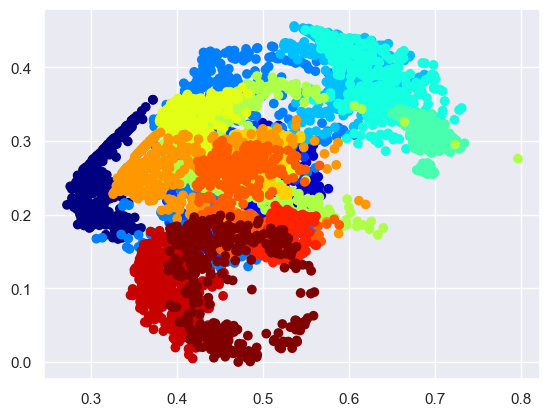

In [24]:
### # Ensamble de inscrustamientos 
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

print("Ensamble por red neuronal (NN)")
print ("")
    
print ("MENU DE ENSAMBLE")
print ("\t1 - FullyConect (nn.Linear) aplicada e Encoders-RD <---")
print ("\t2 - FullyConect (nn.Linear) aplicada e incrustamientos RD originales") 
print ("\tZ - Salir")
#opcionMenu = input("Selecciona una opción >> ")
opcionMenu = "1"
    
if opcionMenu=="1": # Ensamble de modelos encoder por AE
    print ("TIPO DE INCRUSTAMIENTO")
    print ("\t1 - Combination Fashion Top") 
    print ("\t2 - Combination Fashion Dis") 
    print ("\t3 - Combination COIL Top") 
    print ("\t4 - Combination COIL Dis") 
    print ("\t5 - Combination Legos Top") 
    print ("\t6 - Combination Legos (fashion tmb) Dis") 
    #opcionToD = input("Selecciona una opción >> ")
    opcionToD = "3" #<<<<<<*********************
    print("d", d)
    t1 = time()
    combinacion, decodeComb = ensambleRN(listaModelos, opcionToD, 100, d) # penultimo parametro es el numero de epocas
    print("combinacion", combinacion.shape)
    print("tiempo:", time() - t1) 
elif opcionMenu=="2": # Ensamble de métodos DR por AE
    t1 = time()
    combinacion, decodeComb = ensambleRNRD(listaMetodos)
    print("tiempo:", time() - t1)
else :
    print("Salida")

# escala
cmb = torch.from_numpy(combinacion).cuda()
cmb = (cmb - torch.min(cmb))/(torch.max(cmb) - torch.min(cmb))
combinacion =  cmb.cpu().detach().numpy()

guardarRdRnx("DRAE"+opcionToD+nombreDB, combinacion)
graficar(combinacion, False) 

In [ ]:
# METRICA RNX
# :::::::::::::::::::::::::::::::::::::::::::::::
metPca = listaModelos[0]
metLe = listaModelos[1]
metLle = listaModelos[2]
metCmds = listaModelos[3]

from score_rnx import ScoreRnx
score = ScoreRnx()
score.add_high_data(Xin) #Se añaden los datos de alta dimensión
score.add_method('PCA', metPca.rd) # Se añaden los datos de los métodos de reducción de dimensión 
score.add_method('LE', metLe.rd)
score.add_method('LLE', metLle.rd)
score.add_method('CMDS', metCmds.rd)
score.add_method('DRAEt', combinacion)

# De esta manera __get_rnx()__ tendrá en la posición 0 el resultado de evaluación del 
# método CMDS y en la posición 1 el resultado de evaluación del metodo LLE
score.run()
score.generate_graph() 

In [ ]:
# # Métricas de clusters

#matdl = loadFile()1
clusteres(combinacion)
#clusteres(encodeRd)

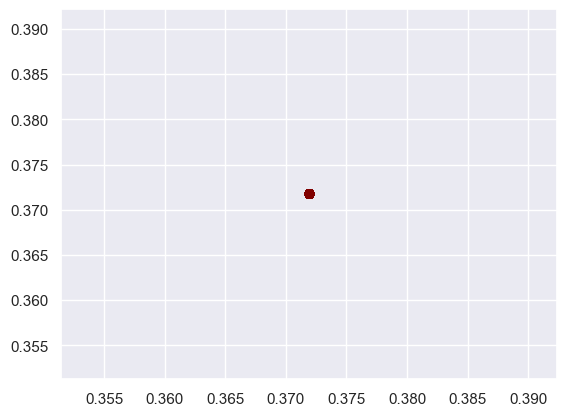

In [19]:
# # Scatter plot de los Rnx de los RD de listaMODELOS

metodo = listaModelos[0]

x=metodo.rd[:,0]
y=metodo.rd[:,1] 
numEt = len(clases)
plt.scatter(x, y, c=labelsIn, label=clases, cmap=plt.cm.get_cmap('jet', numEt))
plt.show()

mdlRd = np.column_stack((metodo.rd, labelsIn)) 
with open('./RNXmat/RDmodelo.dat', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(mdlRd) 



# # Scatter plot de los Rnx de los RD de listaMetodos

# metodo = listaMetodos[0]

# print("METODO: ",metodo.nombre)

# x=metodo.rd[:,0]
# y=metodo.rd[:,1] 
# numEt = len(clases)
# plt.scatter(x, y, c=labelsIn, label=clases, cmap=plt.cm.get_cmap('jet', numEt))
# plt.show()

# with open('./RNXmat/rd'+ metodo.nombre +'CoilPru.dat', 'w', newline='', encoding='utf-8') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerows(metodo.rd) 

# clusteres(metodo.rd)

In [ ]:
# # procedimiento para guardar imagenes del out (decoder)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

from torchvision.utils import save_image
import os

if not os.path.exists('./decodeImgs'):
    os.mkdir('./decodeImgs')
    
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    
    if rowImg==28:
        x = x.view(x.size(0), nCh, 28, 28)
    elif rowImg==32:
        x = x.view(x.size(0), nCh, 32, 32)
    elif rowImg==20:
        x = x.view(x.size(0), nCh, 28, 20)
    
    return x

# guarda las imagenes del out (decode)
decodes=torch.from_numpy(decodeComb).cuda()
#for i in range(len(decodes)):
for i in range(20):
    pic = to_img(decodes[i])
    save_image(pic, './decodeImgs/image_{}.png'.format(i))

In [ ]:
d=2
matl=loadFile("KLEpoliFashionMnist3") # archivos .dat
#matl = loadFileMatlab("deepMklFashion", 'pr') # archivos .mat de MATLAB
clusteres(matl)